#### Predicting EIR and Incidence from Prevalence in 2-10years old and entire population

In [1]:
#Libraries importation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import random
import time

2025-01-05 21:14:22.543037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 21:14:22.560691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 21:14:22.566135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 21:14:22.580303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 21:14:23.644943: W tensorflow/compiler/tf2

In [2]:
#setting seeds
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  8


In [4]:
#Importing functions from split_simulation script
from split_simulations import annual_averages, monthly_values#(years_10-20)

In [5]:
# data loading 
df = pd.read_csv("sim_compendia_train/10000_runs/ANC_Simulation_10000_runs.csv") #ANC data simulated from Malsimgen/Mamasante
annual_averages_df = annual_averages(df)
monthly_values_df = monthly_values(df)

#dataframe saved to CSV
annual_averages_df.to_csv("sim_compendia_train/10000_runs/annual_averages.csv", index=False)
monthly_values_df.to_csv("sim_compendia_train/10000_runs/monthly_values.csv", index=False)

In [6]:
annual_averages_df.head()

,prev_true,EIR_true,prev_2to10,inc_2to10,incall,run,year
0,0.145373,3.040653,0.197861,0.000740,0.000496,1.0,Year_2
1,0.514581,300.244881,0.733250,0.007984,0.006801,1.0,Year_5
2,0.363507,32.603091,0.539678,0.000438,0.000483,1.0,Year_8
3,0.015935,0.134208,0.016619,0.000108,0.000120,2.0,Year_2
4,0.006300,0.048442,0.006466,0.000039,0.000044,2.0,Year_5


#### Exploratory Data Analysis

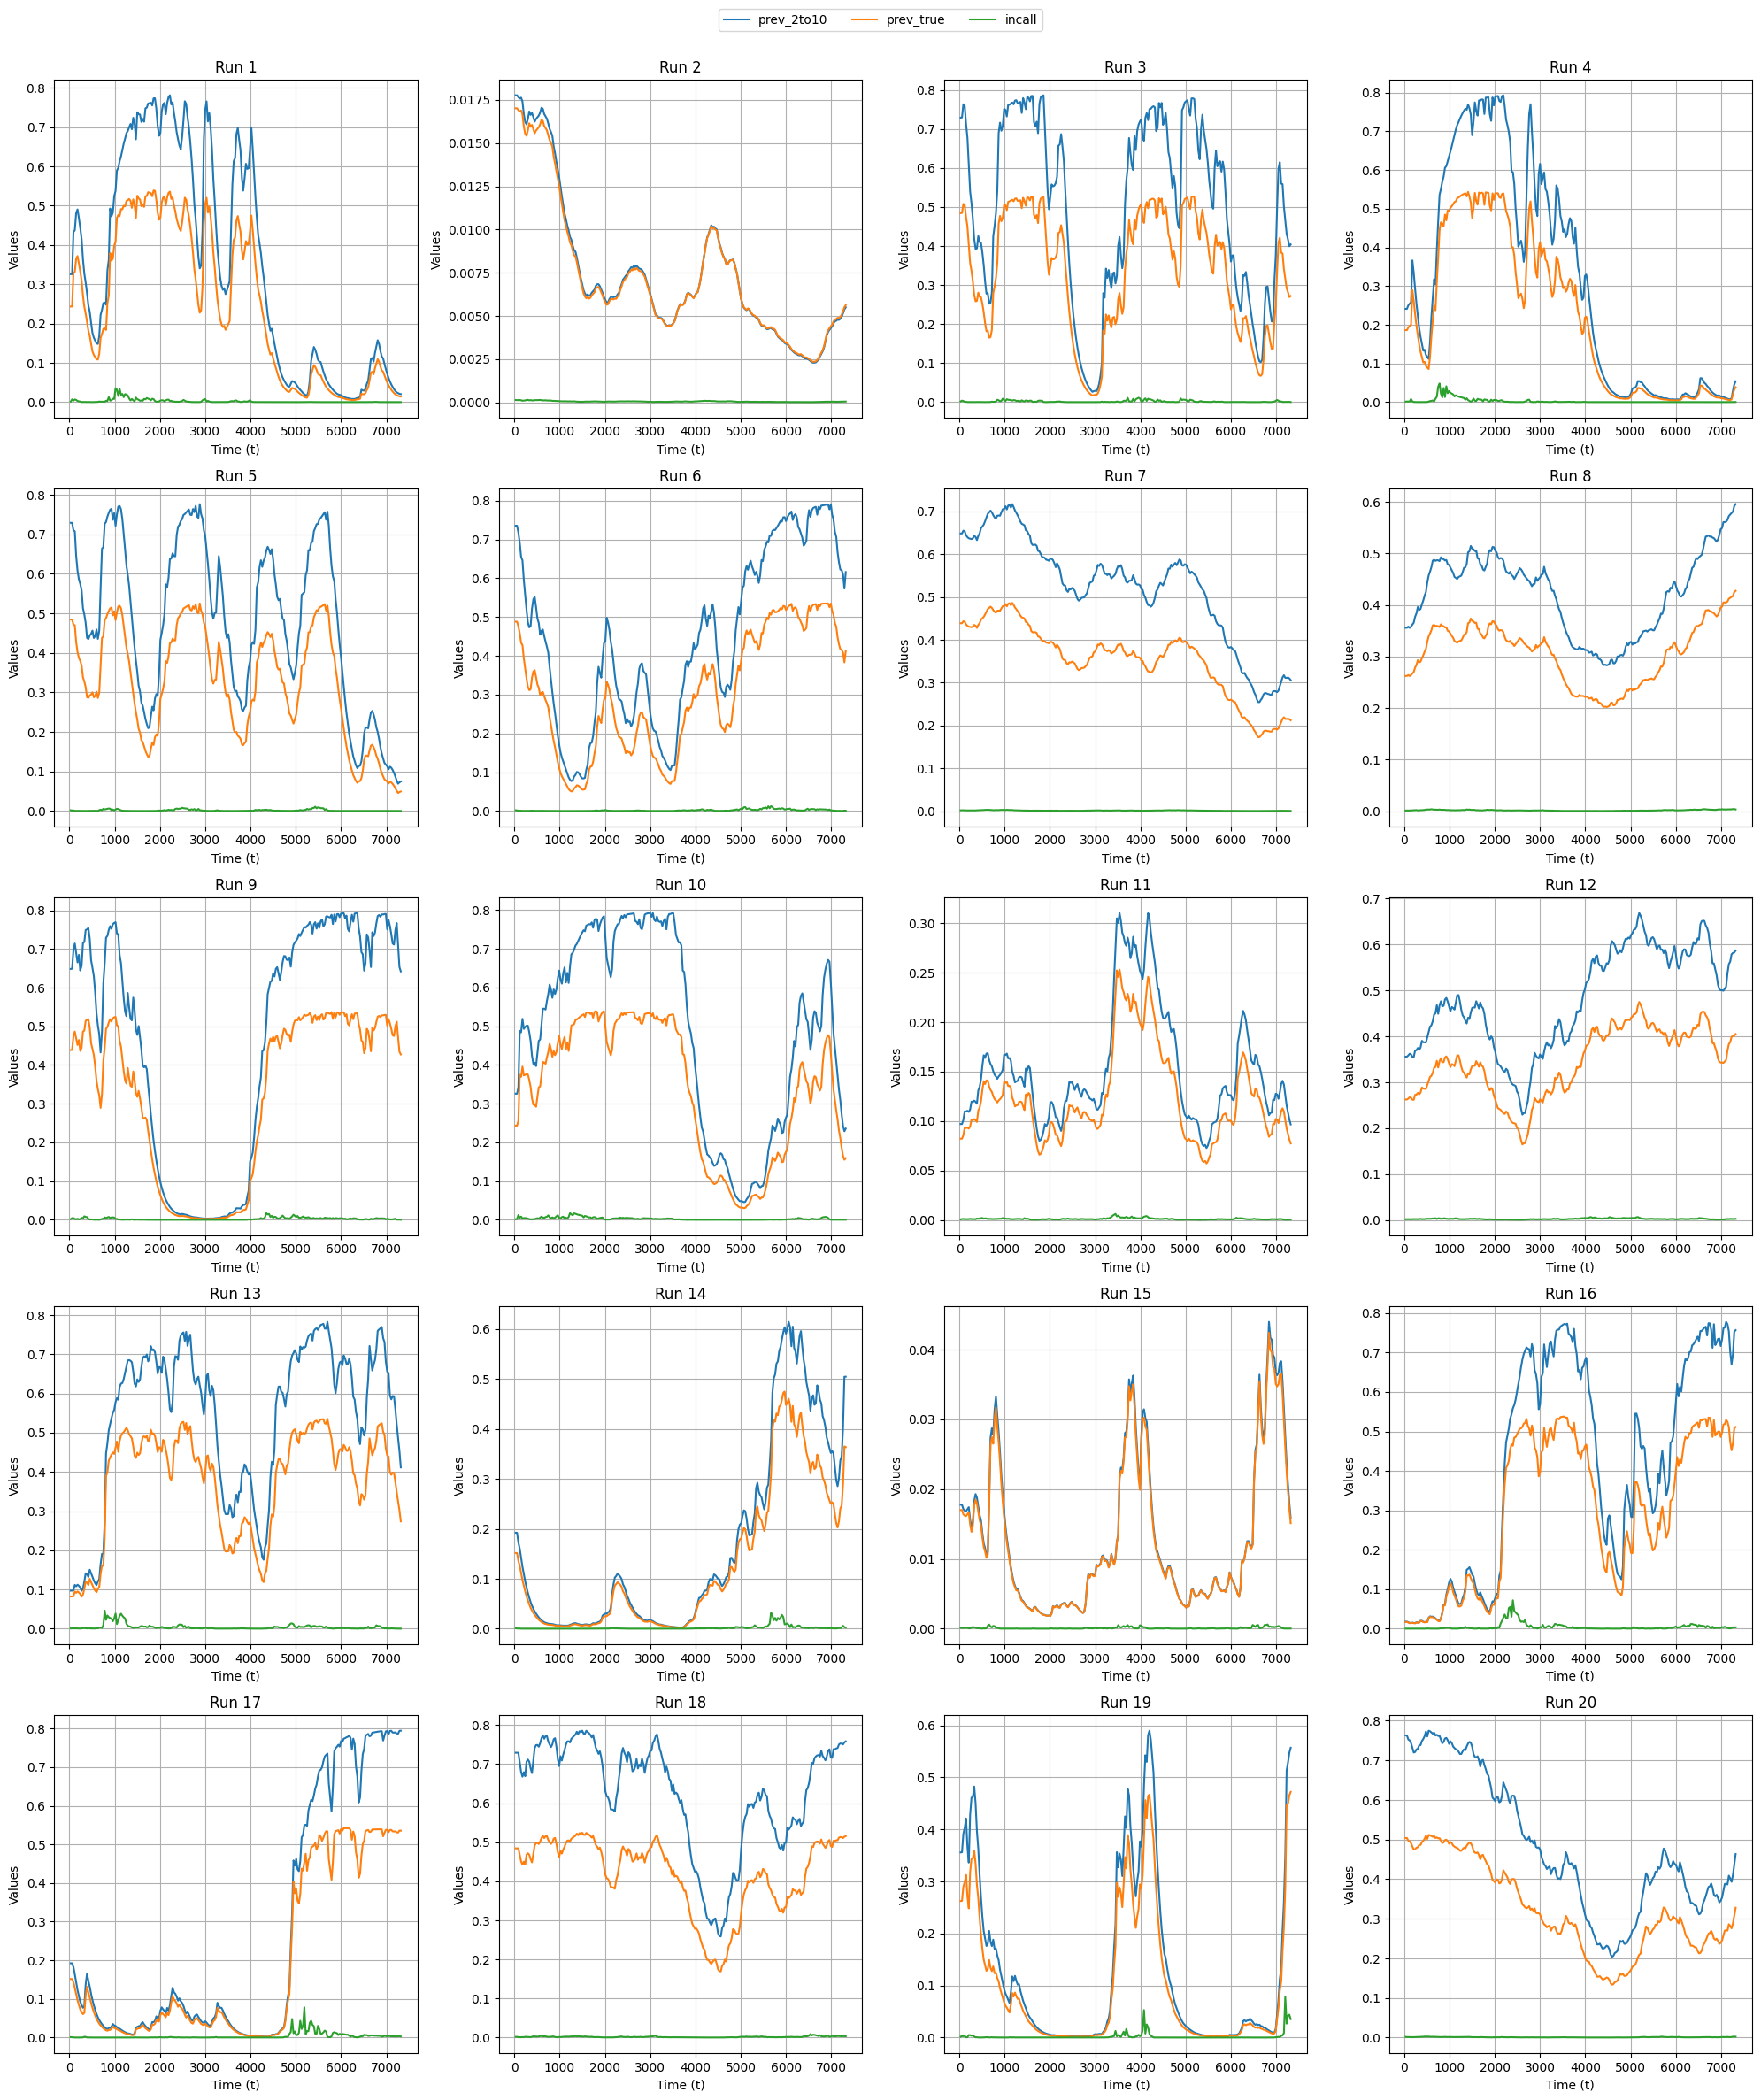

In [7]:
#Plotting prevalance values

def plot_subplots_for_runs(df, num_runs=20):
    #unique runs
    unique_runs = df['run'].unique()[:num_runs]
    columns_to_plot = ["prev_2to10", "prev_true", "incall"]#"inc_2to10",
    
    # Grid size for subplots
    rows = int((num_runs - 1) / 4) + 1  # 4 subplots per row
    cols = 4  # Maximum of 4 subplots per row
    
    # subplots used
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # Flatten to easily index subplots
    
    #line objects for the universal legend
    line_objects = []
    label_objects = []
    
    for i, run in enumerate(unique_runs):
        run_data = df[df['run'] == run]
        
        #column plotted in subplot
        for col in columns_to_plot:
            line, = axes[i].plot(run_data['t'], run_data[col], label=col)
            if col not in label_objects:
                label_objects.append(col)
                line_objects.append(line)
        
        #subplot labels and title
        axes[i].set_title(f'Run {run}')
        axes[i].set_xlabel('Time (t)')
        axes[i].set_ylabel('Values')
        axes[i].grid(True)
    
    # unused subplots hidden
    for j in range(len(unique_runs), len(axes)):
        axes[j].axis('off')
    
    #universal legend
    fig.legend(line_objects, label_objects, loc='upper center', ncol=len(columns_to_plot), bbox_to_anchor=(0.5, 0.95))
    
    #layout
    plt.tight_layout(rect=[0, 0, 1, 0.93])  #space for the legend
    plt.savefig('plots/Prevalence_plot_in_2-10_and_ANC (prev_true).png')
    plt.show()

plot_subplots_for_runs(df, num_runs=20)

In [8]:
train_data = monthly_values_df[monthly_values_df['run'] <= 9500] # 9950 runs used for 
eval_data = monthly_values_df[(monthly_values_df['run'] > 9500) & (monthly_values_df['run'] <= 9800)]
test_data = monthly_values_df[monthly_values_df['run'] > 9800]


In [9]:
train_data.head()

,Unnamed: 0,run,t,prev_true,EIR_true,vol_true,tested,positive,prev_2to10,inc_2to10,incall
121,122,1,3660,0.418846,169.112468,0.8,259,110,0.621501,0.004945,0.004459
122,123,1,3690,0.462078,170.812027,0.8,278,121,0.682529,0.004643,0.003913
123,124,1,3720,0.473562,79.639874,0.8,261,119,0.697843,0.002113,0.001770
124,125,1,3750,0.452692,55.647647,0.8,227,96,0.668002,0.001557,0.001350
125,126,1,3780,0.434022,12.378064,0.8,177,72,0.641120,0.000358,0.000312


In [10]:
# preprocessing (Log transform function)
def log_transform(data):
    return np.log(data)

# Inverse log transform function
def inverse_log_transform(data):
   return np.exp(data)

# Log transforming our data
train_data_scaled = train_data[["prev_2to10", "prev_true", "incall","EIR_true"]].apply(log_transform)
eval_data_scaled = eval_data[["prev_2to10", "prev_true", "incall", "EIR_true"]].apply(log_transform)
test_data_scaled = test_data[["prev_2to10", "prev_true", "incall", "EIR_true"]].apply(log_transform)

In [11]:
# Importing sequence function from script
from sequence_creator_multi_inputs_outputs import create_sequences

In [12]:
# Creating sequences
window_size = 10
X_train, y_train = create_sequences(train_data_scaled, window_size)
X_eval, y_eval = create_sequences(eval_data_scaled, window_size)
X_test, y_test = create_sequences(test_data_scaled, window_size)

#saving sequences for resuablility
np.savez('src/seq/train_sequences.npz', X=X_train, y=y_train)
np.savez('src/seq/eval_sequences.npz', X=X_eval, y=y_eval)
np.savez('src/seq/test_sequences.npz', X=X_test, y=y_test)

# train_data = np.load('train_sequences.npz')
# X_train, y_train = train_data['X'], train_data['y']

# eval_data = np.load('eval_sequences.npz')
# X_eval, y_eval = eval_data['X'], eval_data['y']

In [13]:
#Shuffling training Sequences in Unison to introduce more randomness(volatility)
shuffled_indices = np.random.permutation(len(X_train))

X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [14]:
seq_length = 2*window_size + 1 

In [15]:
# Defining architectures to experiment with
architectures = {
    "2_layers": [128, 64],
    "3_layers": [200, 100, 50],
    "4_layers": [256, 128, 64, 32],
    "5_layers": [300, 200, 100, 50, 25],
    "6_layers": [400, 300, 200, 100, 50, 25]
}

In [16]:
#loading model function
from model_exp import create_experiment_model

In [17]:
# results tracking 
results = []
for name, architecture in architectures.items():
    print(f"Training model: {name}")
    model = create_experiment_model(seq_length, architecture)
    model.summary()
    start_time = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_eval, y_eval), epochs=15, batch_size=32, verbose=0)
    duration = time.time() - start_time
    results.append({
        "name": name,
        "model": model,
        "history": history,
        "duration": duration,
        "parameters": model.count_params()
    })
    model.save(f"src/model/{name}_model_10000runs_w10.keras")

Training model: 2_layers


2025-01-05 21:28:57.323523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22054 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:27:00.0, compute capability: 8.6
2025-01-05 21:28:57.324866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22256 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:28:00.0, compute capability: 8.6
2025-01-05 21:28:57.325881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22256 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:43:00.0, compute capability: 8.6
2025-01-05 21:28:57.326900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22256 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:44:00.0, 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,610 (455.51 KB)

 Trainable params: 116,610 (455.51 KB)

 Non-trainable params: 0 (0.00 B)

2025-01-05 21:29:06.093109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


Training model: 3_layers


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 21, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 21, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,102 (1.19 MB)

 Trainable params: 313,102 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Training model: 4_layers


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 21, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 21, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 21, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,226 (2.00 MB)

 Trainable params: 524,226 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Training model: 5_layers


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 21, 300)        │       363,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 21, 200)        │       400,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 21, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 21, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,652 (3.52 MB)

 Trainable params: 922,652 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Training model: 6_layers


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 21, 400)        │       644,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 21, 300)        │       841,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 21, 200)        │       400,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 21, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 21, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,045,052 (7.80 MB)

 Trainable params: 2,045,052 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

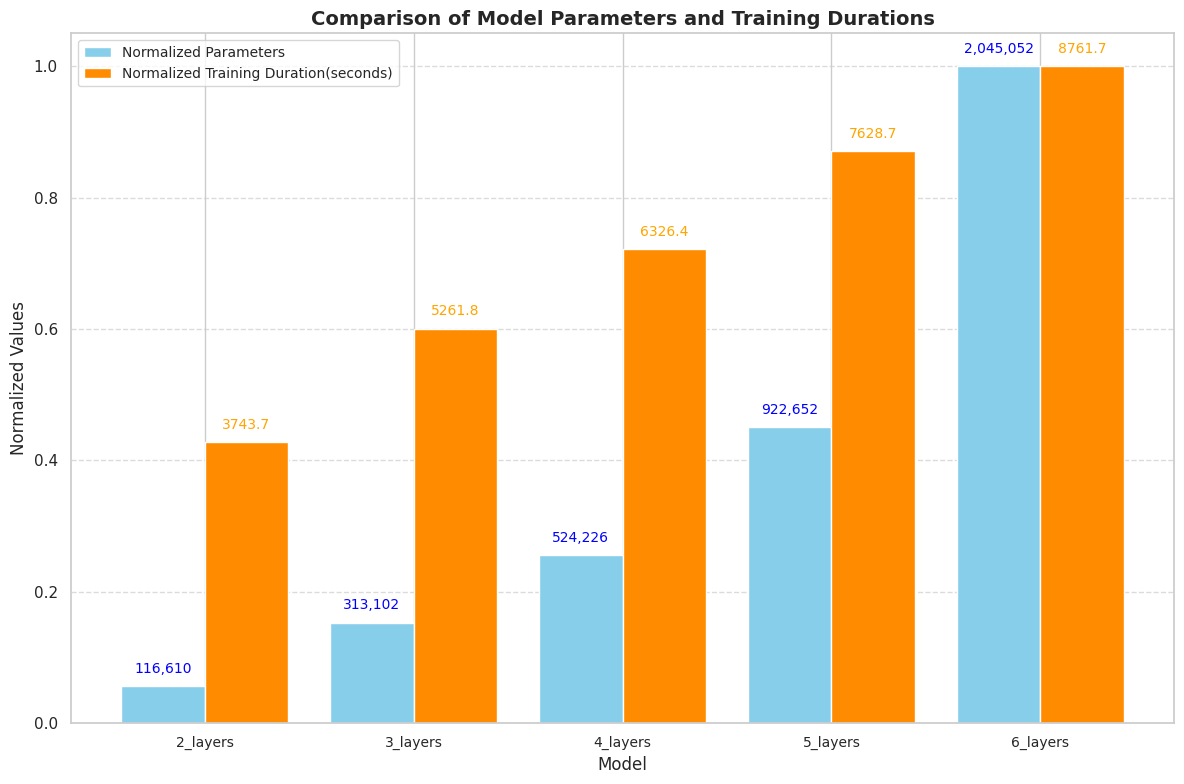

In [18]:
# Model names and metrics
model_names = [result['name'] for result in results]
parameters = [result['parameters'] for result in results]
durations = [result['duration'] for result in results]

# Normalized values for comparison
max_params = max(parameters)
max_durations = max(durations)
normalized_params = [p / max_params for p in parameters]
normalized_durations = [d / max_durations for d in durations]

#grouped bar plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(model_names))  # the label locations
bar_width = 0.4

# Plotting normalized values
bar1 = ax.bar(x - bar_width / 2, normalized_params, bar_width, label="Normalized Parameters", color="skyblue")
bar2 = ax.bar(x + bar_width / 2, normalized_durations, bar_width, label="Normalized Training Duration(seconds)", color="darkorange")

# Adding value annotations
for bar, param in zip(bar1, parameters):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{param:,}", ha="center", fontsize=10, color="blue")
for bar, duration in zip(bar2, durations):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{duration:.1f}", ha="center", fontsize=10, color="orange")

# Axis labels and title
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Normalized Values", fontsize=12)
ax.set_title("Comparison of Model Parameters and Training Durations", fontsize=14, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=10)
ax.legend(fontsize=10)

# Grid and layout
ax.grid(axis="y", linestyle="--", alpha=0.7)
fig.tight_layout()

plt.savefig("plots/Comparison of Model Parameters and Training Durations.png", dpi=300)
plt.show()


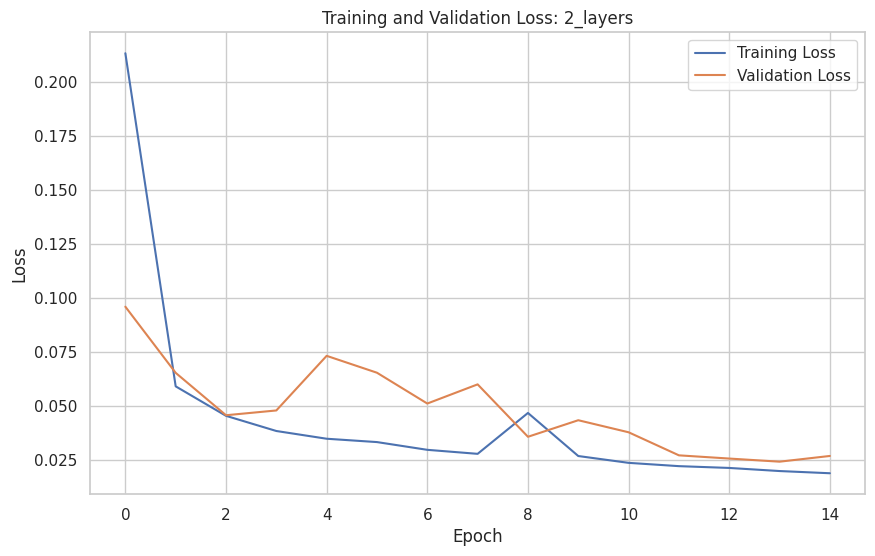

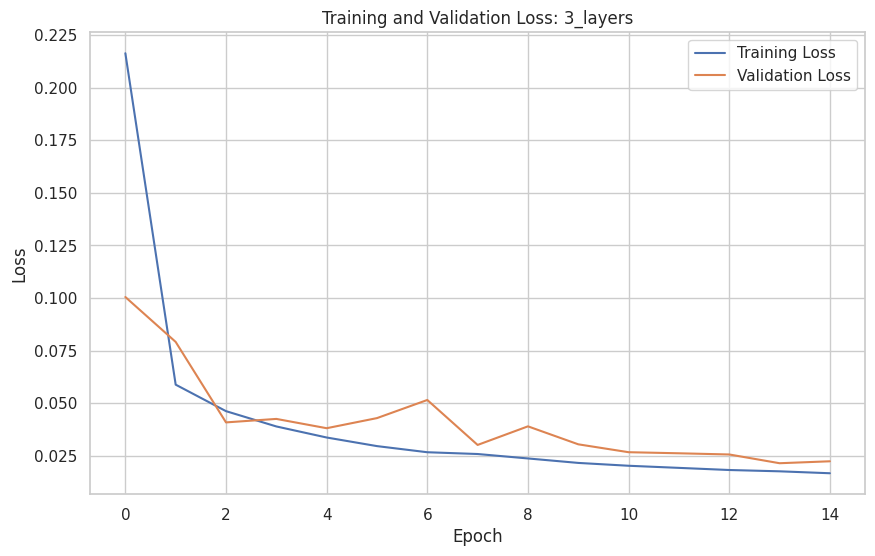

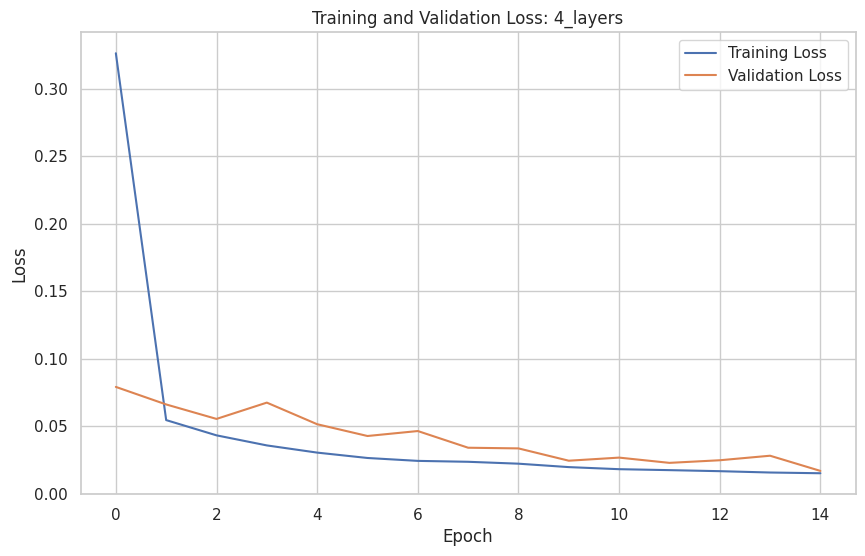

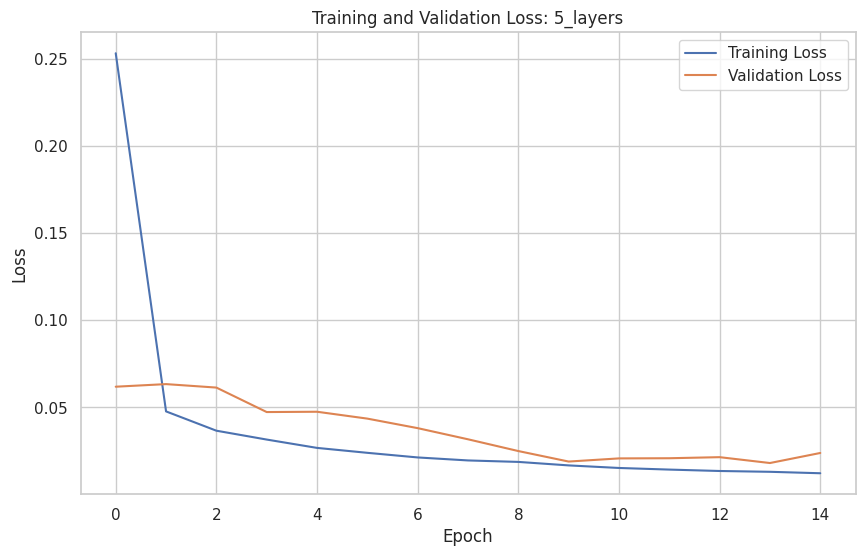

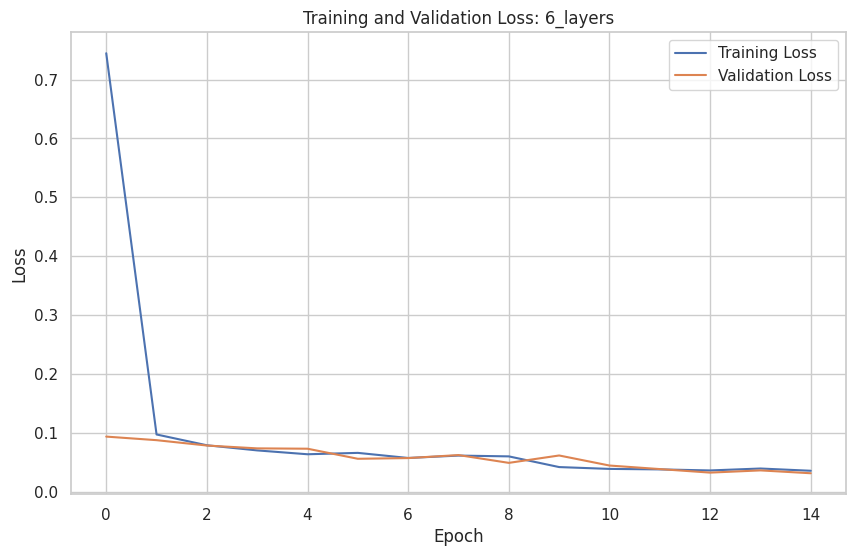

In [19]:
# Training and Validation Metrics (loss function)
for result in results:
    plt.figure(figsize=(10, 6))
    history = result['history']
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss: {result['name']}")
    plt.legend()
    plt.show()

36516/36516 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step
36516/36516 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step
36516/36516 ━━━━━━━━━━━━━━━━━━━━ 130s 4ms/step
36516/36516 ━━━━━━━━━━━━━━━━━━━━ 153s 4ms/step
36516/36516 ━━━━━━━━━━━━━━━━━━━━ 175s 5ms/step
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


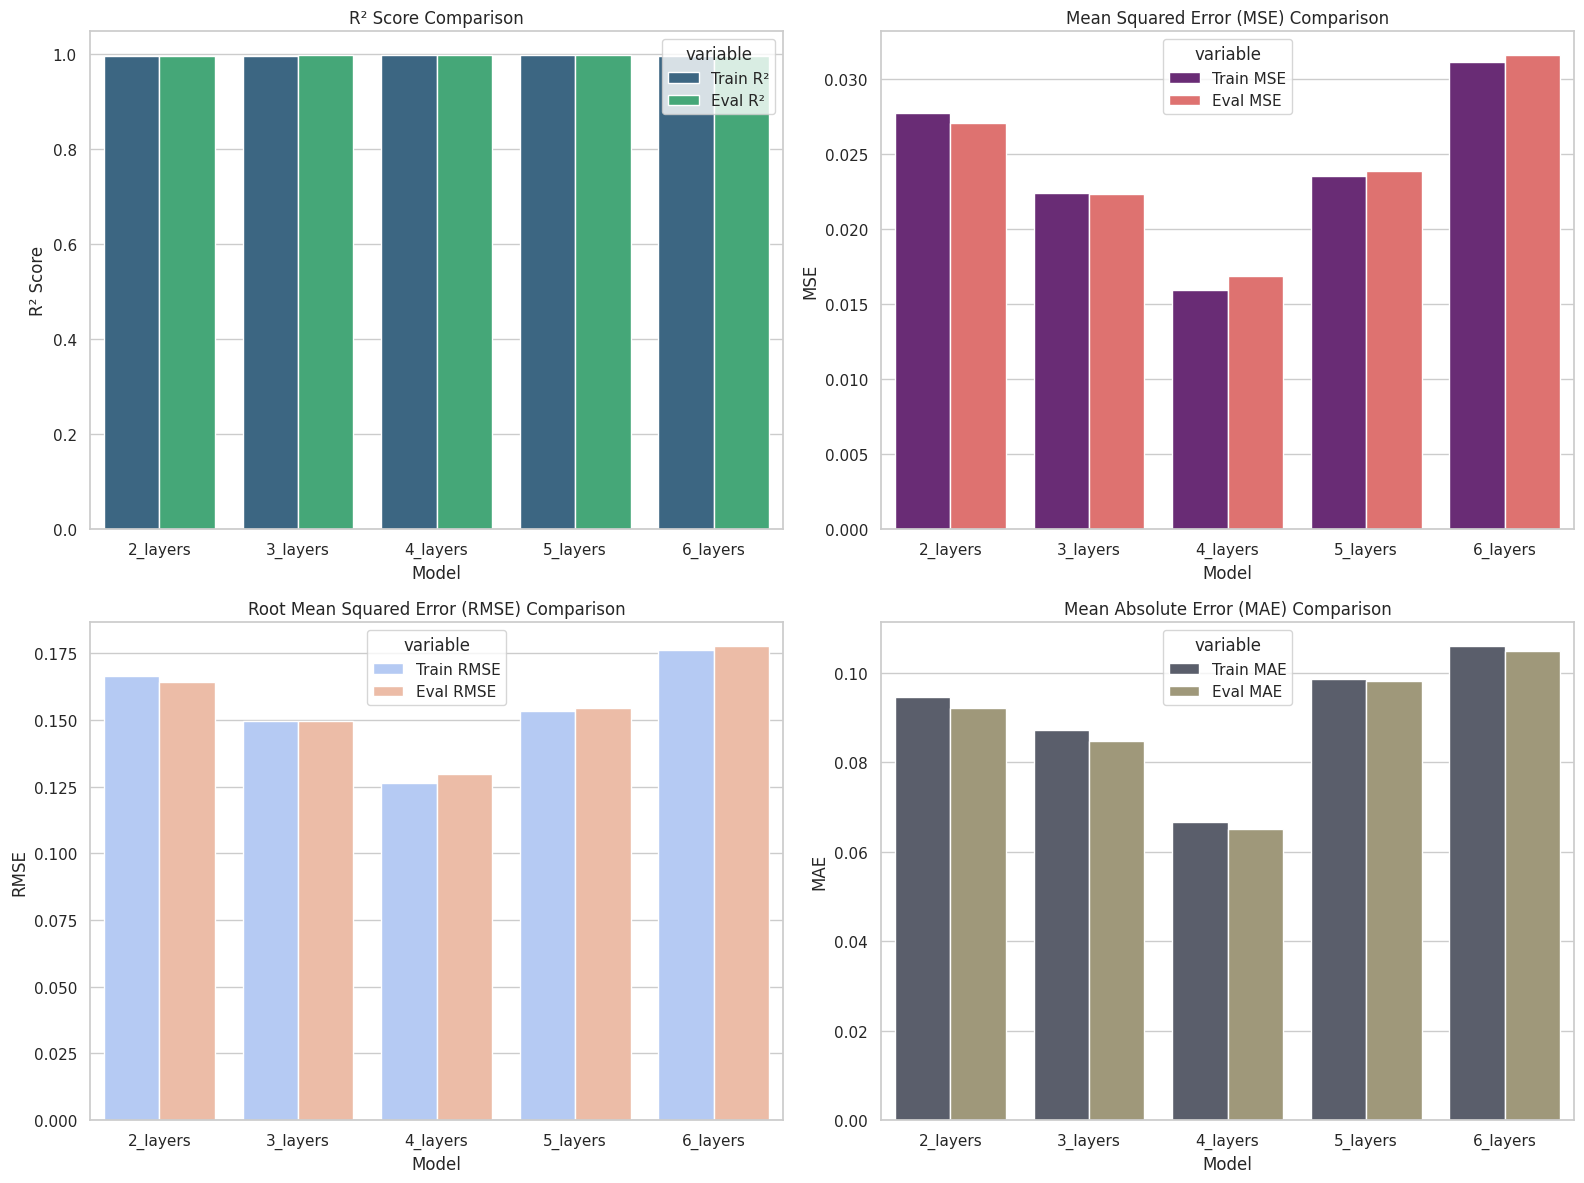

In [20]:
#Plot of Performance metrics

y_train_pred_list = [model.predict(X_train) for model in [result['model'] for result in results]]
y_eval_pred_list = [model.predict(X_eval) for model in [result['model'] for result in results]]

# Metrics calculation
metrics_data = []
for idx, result in enumerate(results):
    y_train_pred = y_train_pred_list[idx]
    y_eval_pred = y_eval_pred_list[idx]
    
    #metrics for training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    #metrics for evaluation set
    eval_r2 = r2_score(y_eval, y_eval_pred)
    eval_mse = mean_squared_error(y_eval, y_eval_pred)
    eval_rmse = np.sqrt(eval_mse)
    eval_mae = mean_absolute_error(y_eval, y_eval_pred)
    
    metrics_data.append({
        "Model": result['name'],
        "Train R²": train_r2, "Eval R²": eval_r2,
        "Train MSE": train_mse, "Eval MSE": eval_mse,
        "Train RMSE": train_rmse, "Eval RMSE": eval_rmse,
        "Train MAE": train_mae, "Eval MAE": eval_mae
    })

# Converting to structured form for visualization
metrics_df = pd.DataFrame(metrics_data)

# Plotting
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: R²
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train R²", "Eval R²"]),
            x="Model", y="value", hue="variable", palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("R² Score Comparison")
axes[0, 0].set_ylabel("R² Score")

# Subplot 2: MSE
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MSE", "Eval MSE"]),
            x="Model", y="value", hue="variable", palette="magma", ax=axes[0, 1])
axes[0, 1].set_title("Mean Squared Error (MSE) Comparison")
axes[0, 1].set_ylabel("MSE")

# Subplot 3: RMSE
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train RMSE", "Eval RMSE"]),
            x="Model", y="value", hue="variable", palette="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title("Root Mean Squared Error (RMSE) Comparison")
axes[1, 0].set_ylabel("RMSE")

# Subplot 4: MAE
sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MAE", "Eval MAE"]),
            x="Model", y="value", hue="variable", palette="cividis", ax=axes[1, 1])
axes[1, 1].set_title("Mean Absolute Error (MAE) Comparison")
axes[1, 1].set_ylabel("MAE")

#layout
fig.tight_layout()
plt.savefig("plots/models_performance_metrics_comparison.png")
plt.show()
